# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from sklearn.preprocessing import LabelEncoder
from implicit.als import AlternatingLeastSquares
from catboost import CatBoostClassifier, Pool
import boto3
import os
from dotenv import load_dotenv
import seaborn as sns

/home/mle-user/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [3]:
tracks = pd.read_parquet('tracks.parquet')
catalog_names = pd.read_parquet('catalog_names.parquet')
interactions = pd.read_parquet('interactions.parquet')

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [4]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


In [5]:
tracks.head(2)

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"


In [6]:
# Преобразуем списки в кортежи
tracks['albums'] = tracks['albums'].apply(tuple)
tracks['artists'] = tracks['artists'].apply(tuple)
tracks['genres'] = tracks['genres'].apply(tuple)

In [7]:
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [8]:
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [9]:
catalog_names.type.value_counts()

type
track     1000000
album      658724
artist     153581
genre         166
Name: count, dtype: int64

In [10]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


In [11]:
# Проверка дубликатов
print(f"Дубликаты в tracks: {tracks.duplicated().sum()}")
print(f"Дубликаты в catalog_names: {catalog_names.duplicated().sum()}")
# print(f"Дубликаты в interactions: {interactions.duplicated().sum()}")

Дубликаты в tracks: 0
Дубликаты в catalog_names: 0


In [12]:
# Проверка пустых
print(f"Пустые в tracks: {tracks.isna().sum()}")
print(f"Пустые в catalog_names: {catalog_names.isna().sum()}")

Пустые в tracks: track_id    0
albums      0
artists     0
genres      0
dtype: int64
Пустые в catalog_names: id      0
type    0
name    0
dtype: int64


Приведём выводы по первому знакомству с данными:

- есть ли с данными явные проблемы
- какие корректирующие действия (в целом) были предприняты

С данными проблем нет. Все типы правильные, пропуски отсутствуют

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

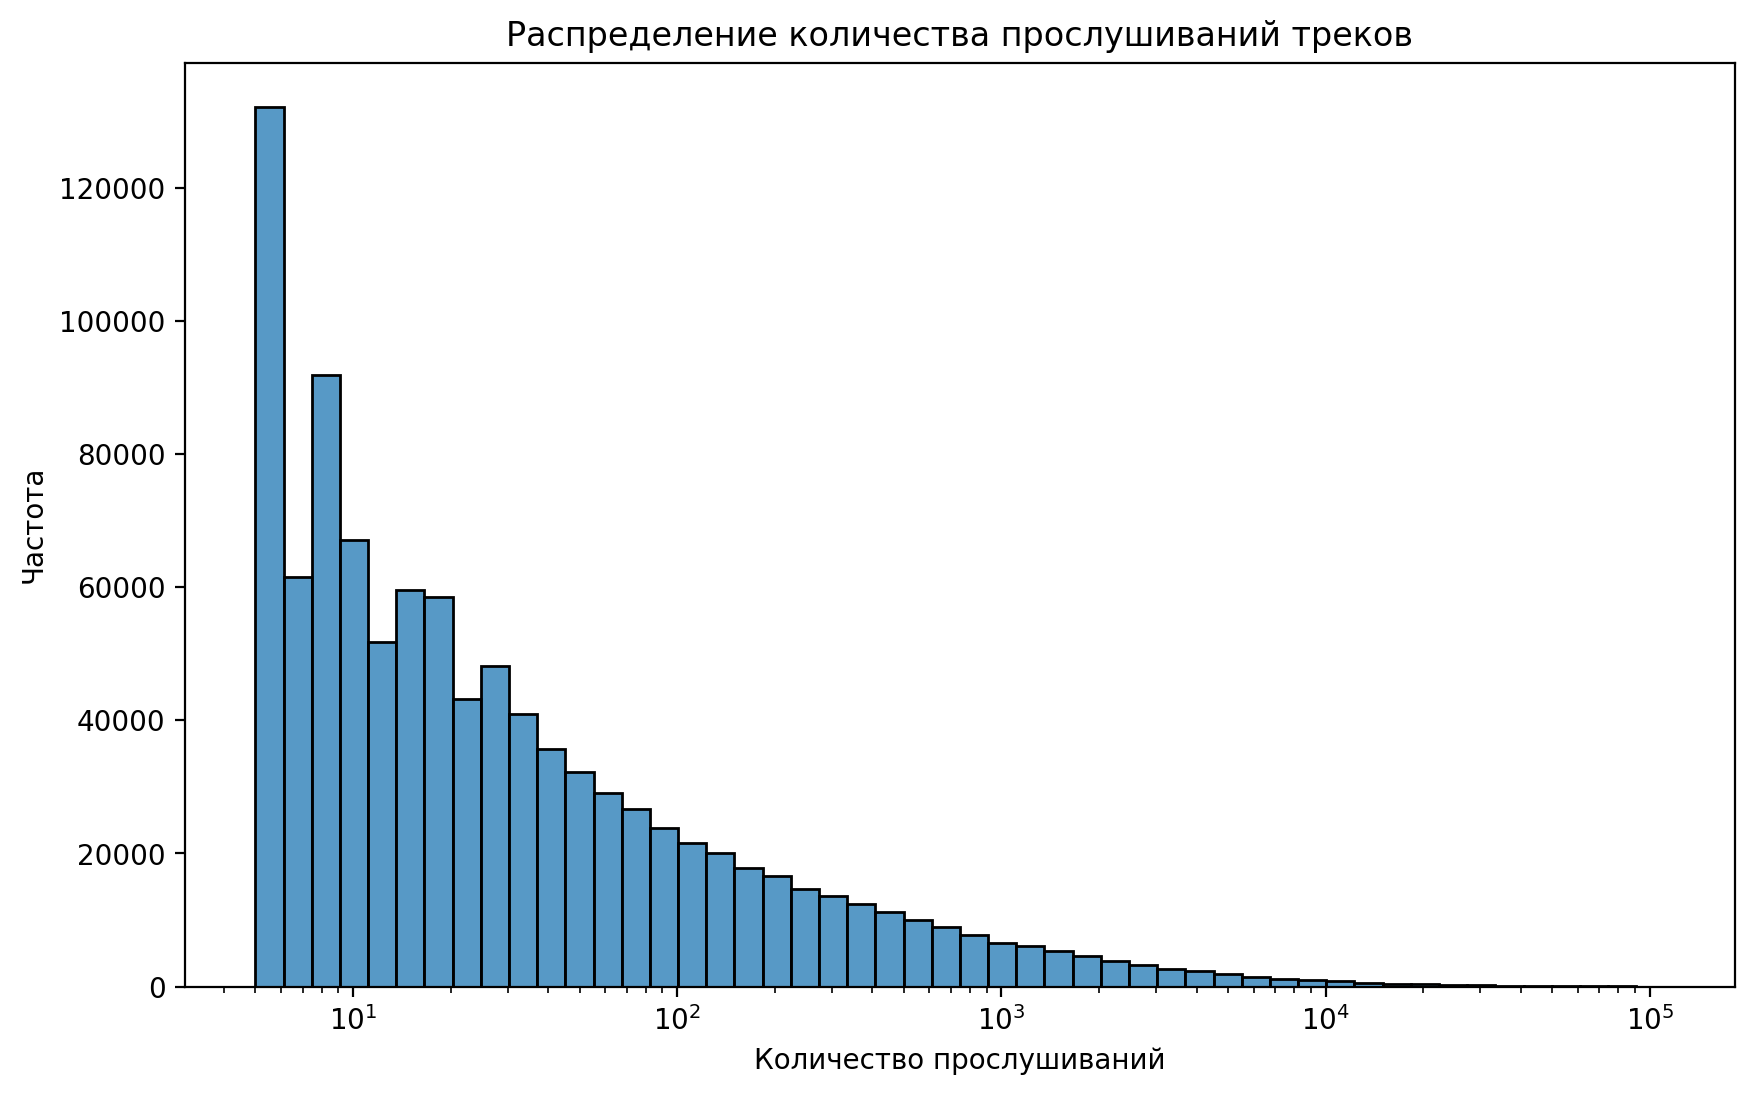

In [13]:
# Группировка по track_id для подсчета количества прослушиваний
track_listen_counts = interactions.groupby('track_id').size().reset_index(name='listen_count')

# Визуализация распределения
plt.figure(figsize=(10, 6))
sns.histplot(track_listen_counts['listen_count'], bins=50, log_scale=True)
plt.title('Распределение количества прослушиваний треков')
plt.xlabel('Количество прослушиваний')
plt.ylabel('Частота')
plt.show()

Наиболее популярные треки

In [14]:
# Объединяем данные о треках и количестве прослушиваний
tracks_with_listen_counts = tracks.merge(
    track_listen_counts,
    left_on='track_id',
    right_on='track_id',
    how='left'
)

# Добавляем названия треков из catalog_names
tracks_with_names = tracks_with_listen_counts.merge(
    catalog_names[catalog_names['type'] == 'track'],
    left_on='track_id',
    right_on='id',
    how='left'
)

# Топ-10 самых популярных треков
top_tracks = tracks_with_names.sort_values(by='listen_count', ascending=False).head(10)
top_tracks[['track_id', 'name', 'listen_count']]

,track_id,name,listen_count
9098,53404,Smells Like Teen Spirit,111062
483876,33311009,Believer,106921
26665,178529,Numb,101924
512157,35505245,I Got Love,99490
829320,65851540,Юность,86670
368072,24692821,Way Down We Go,86246
475289,32947997,Shape of You,85886
696106,51241318,In The End,85244
90461,795836,Shape Of My Heart,85042
647237,45499814,Life,84748


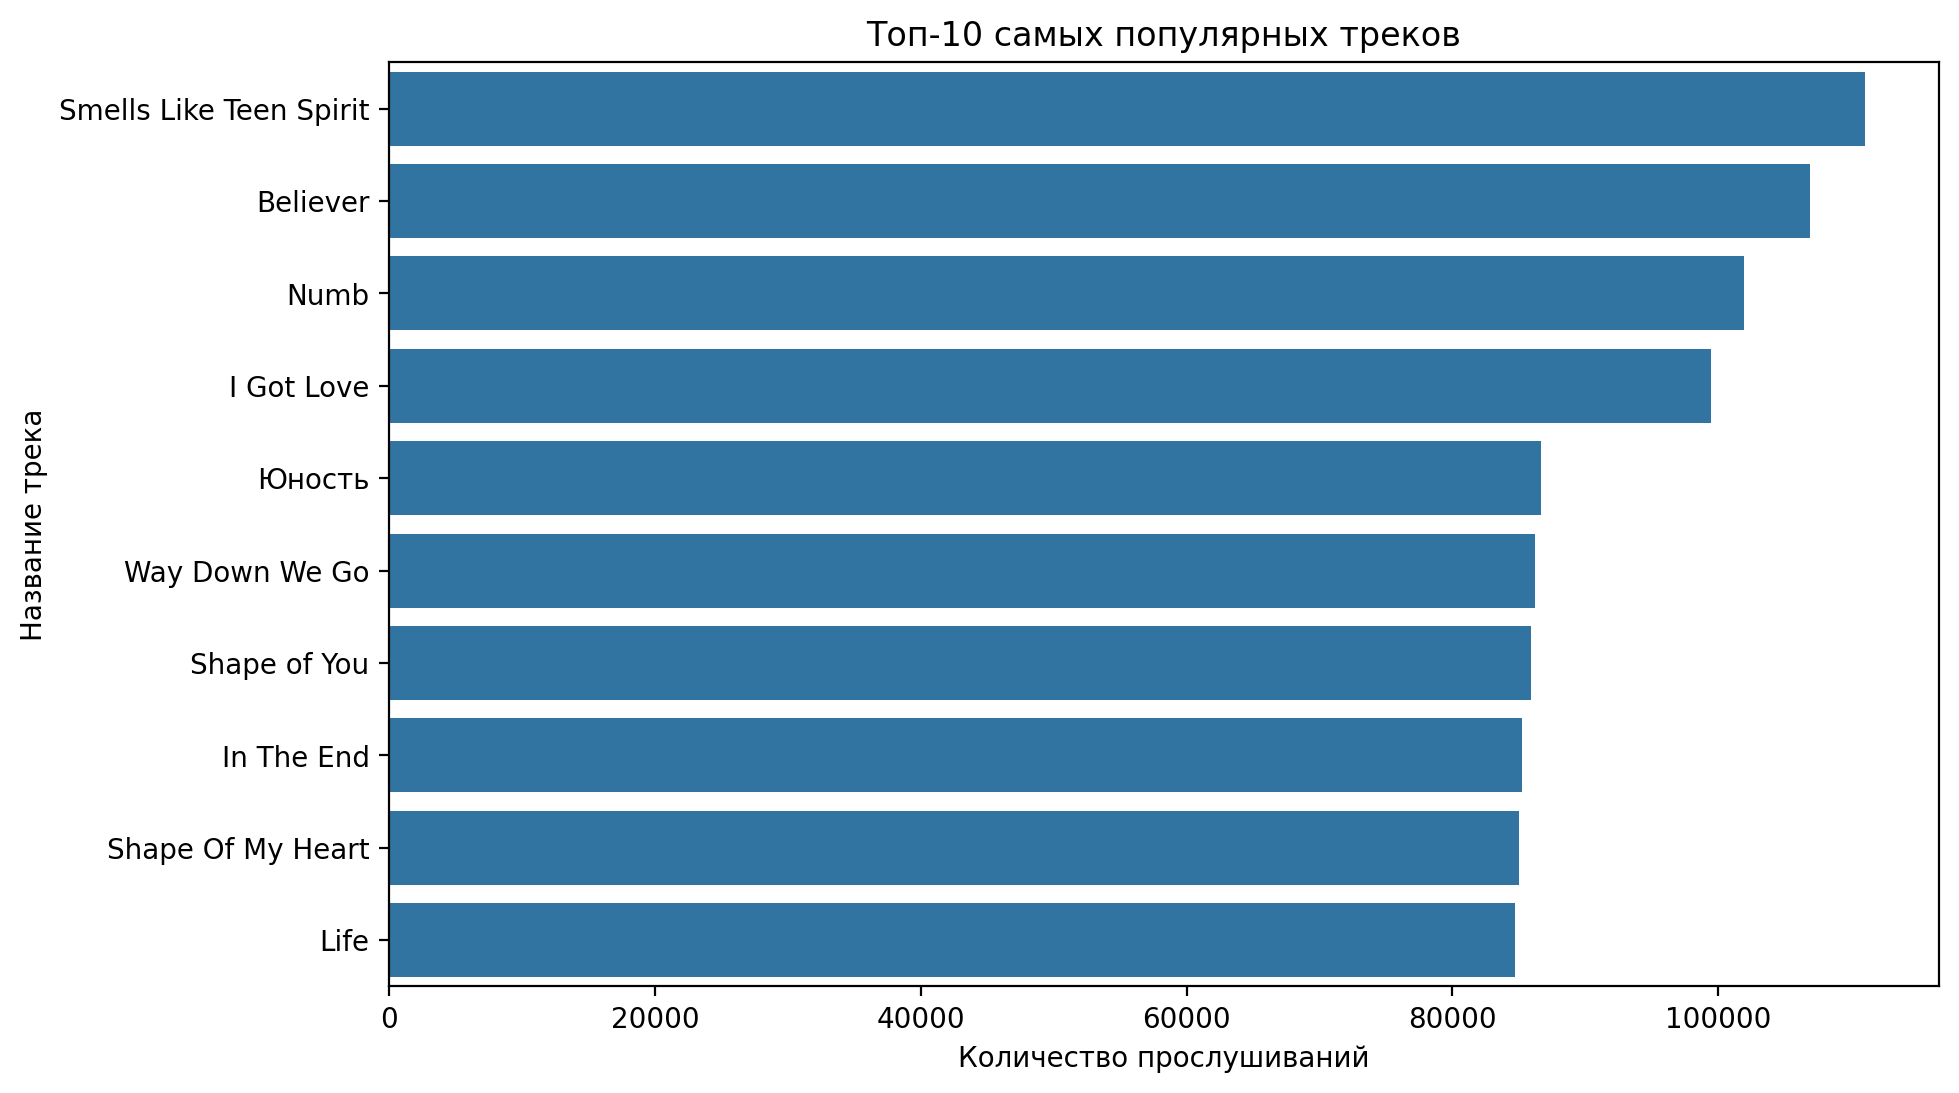

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(data=top_tracks, x='listen_count', y='name', orient='h')
plt.title('Топ-10 самых популярных треков')
plt.xlabel('Количество прослушиваний')
plt.ylabel('Название трека')
plt.show()

Наиболее популярные жанры

In [16]:
# Разворачиваем список жанров для каждого трека
tracks_exploded = tracks.explode('genres')

# Объединяем с данными о прослушиваниях
tracks_with_genres = tracks_exploded.merge(
    track_listen_counts,
    left_on='track_id',
    right_on='track_id',
    how='left'
)

# Группируем по жанрам и суммируем количество прослушиваний
genre_popularity = tracks_with_genres.groupby('genres')['listen_count'].sum().reset_index()

# Добавляем названия жанров из catalog_names
genre_popularity_with_names = genre_popularity.merge(
    catalog_names[catalog_names['type'] == 'genre'],
    left_on='genres',
    right_on='id',
    how='left'
)

# Топ-10 самых популярных жанров
top_genres = genre_popularity_with_names.sort_values(by='listen_count', ascending=False).head(10)
top_genres[['genres', 'name', 'listen_count']]

,genres,name,listen_count
10,11,pop,55578312
70,75,rap,37799821
95,102,allrock,31092013
19,20,ruspop,26626241
2,3,rusrap,25303695
63,68,electronics,20120981
15,16,dance,16291557
1,2,rusrock,13166147
13,14,rock,12772644
42,47,metal,12437375


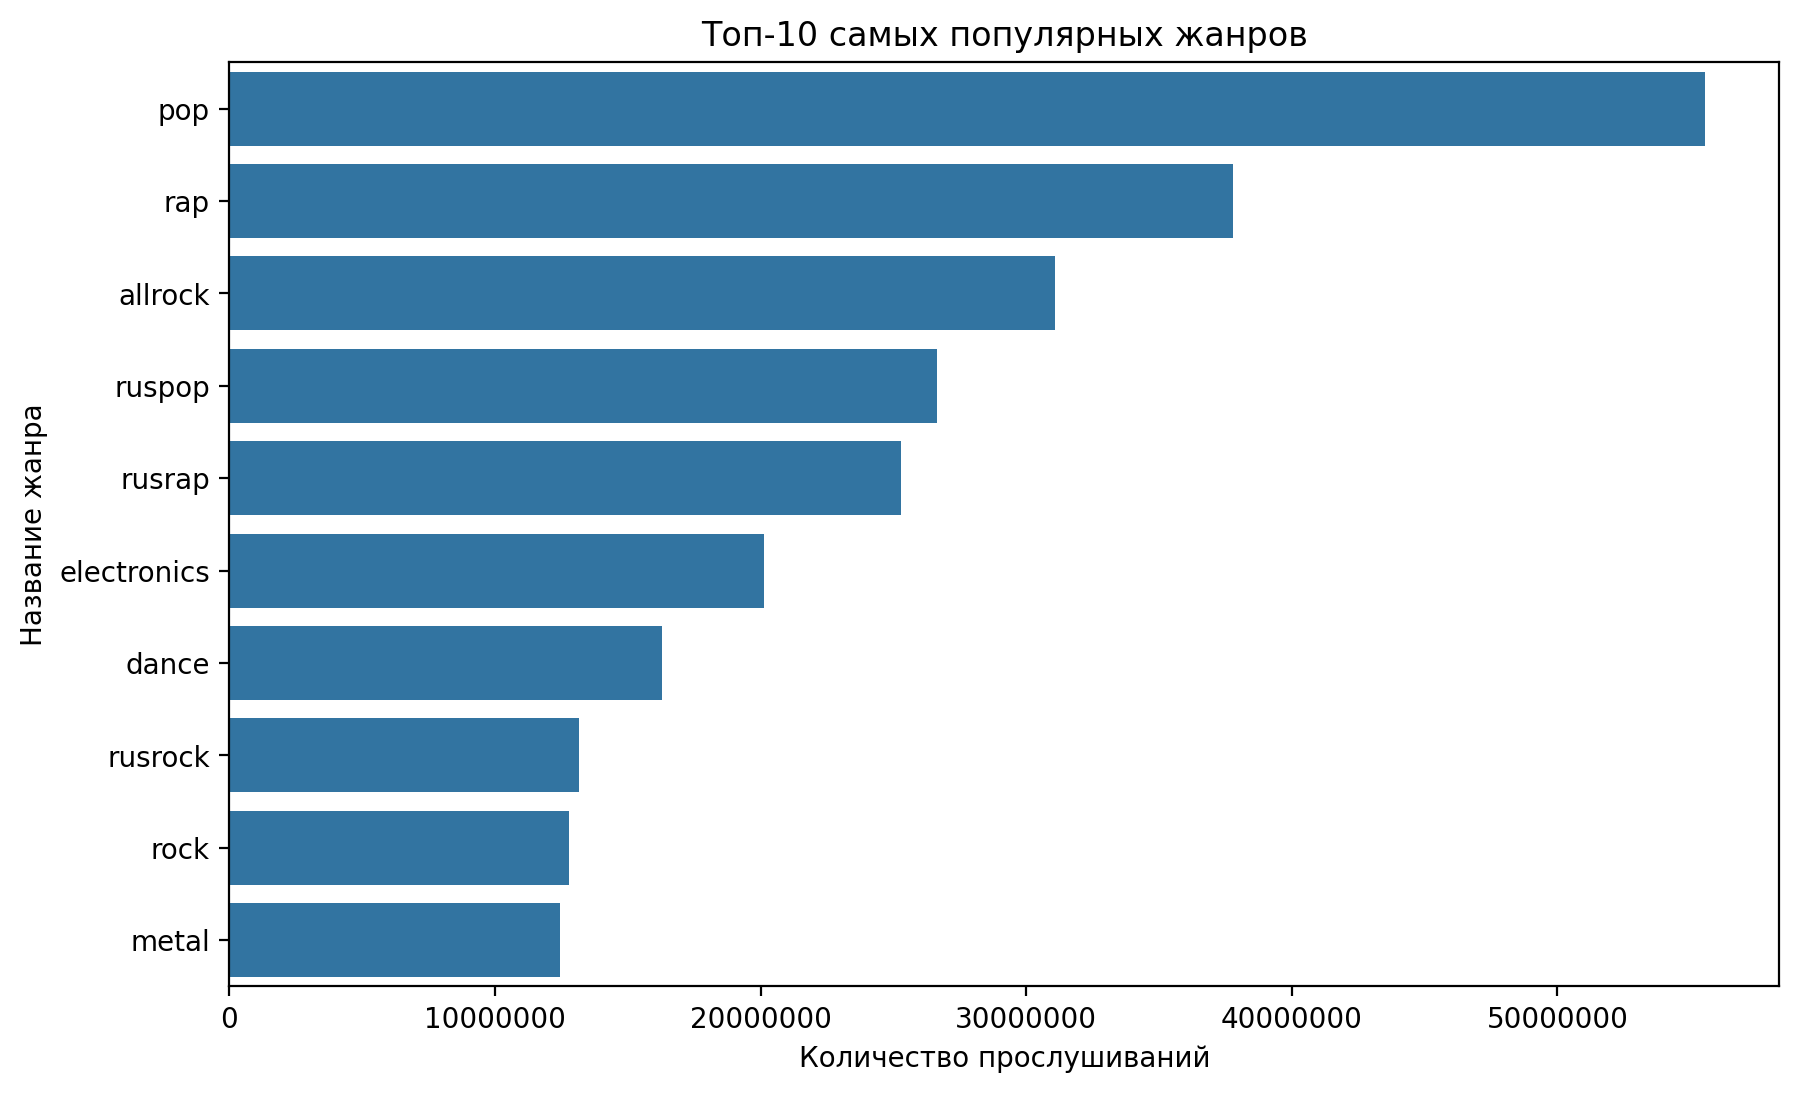

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(data=top_genres, x='listen_count', y='name')
plt.title('Топ-10 самых популярных жанров')
plt.xlabel('Количество прослушиваний')
plt.ylabel('Название жанра')
# Форматирование оси X
plt.ticklabel_format(style='plain', axis='x')  # Отключаем научную нотацию
plt.show()

Треки, которые никто не прослушал

In [18]:
# Треки, которые не были прослушаны
unlistened_tracks = tracks[~tracks['track_id'].isin(interactions['track_id'])]

# Добавляем названия треков из catalog_names
unlistened_tracks_with_names = unlistened_tracks.merge(
    catalog_names[catalog_names['type'] == 'track'],
    left_on='track_id',
    right_on='id',
    how='left'
)

print(f"Количество непрослушанных треков: {len(unlistened_tracks_with_names)}")

Количество непрослушанных треков: 0


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [19]:
# добавим названия треков
tracks = catalog_names.query("type == 'track'").rename(columns={"id": "track_id"}).merge(tracks, on="track_id", how='right').drop(columns="type")

In [20]:
items = tracks.copy()
events = interactions.copy()

In [21]:
items.rename(columns={"track_id": "item_id"}, inplace=True)
events.rename(columns={"track_id": "item_id"}, inplace=True)

In [23]:
# перекодируем item_id
item_encoder = LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
events["item_id_enc"] = item_encoder.transform(events["item_id"])

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [23]:
items.to_parquet("items.parquet")

In [24]:
events.to_parquet("events.parquet")

In [25]:
import os
import boto3
from dotenv import load_dotenv

load_dotenv()

AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

session = boto3.Session(
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name="ru-central1"
)

print(session.client.__code__)

s3_client = session.client(
    service_name='s3',
    endpoint_url='https://storage.yandexcloud.net'
)

print(session.client.__code__)


<code object client at 0x7f6bad413730, file "/home/mle-user/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/boto3/session.py", line 235>
<code object client at 0x7f6bad413730, file "/home/mle-user/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/boto3/session.py", line 235>


In [3]:
load_dotenv()

AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
bucket_name = os.getenv("S3_BUCKET_NAME")
url = 'https://storage.yandexcloud.net'

session = boto3.Session(
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name="us-east-1",
)

s3_client = session.client(
    service_name='s3',
    endpoint_url=url   
)

In [27]:
s3_client.upload_file(Filename='items.parquet', Bucket=bucket_name, Key='recsys/data/items.parquet')

In [ ]:
s3_client.upload_file(Filename='events.parquet', Bucket=bucket_name, Key='recsys/data/events.parquet')

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [9]:
load_dotenv()

AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
bucket_name = os.getenv("S3_BUCKET_NAME")
url = 'https://storage.yandexcloud.net'

session = boto3.Session(
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name="ru-central1",
)

s3_client = session.client(
    service_name='s3',
    endpoint_url=url   
)

In [4]:
s3_client.download_file(Bucket=bucket_name, Key='recsys/data/items.parquet', Filename="items.parquet")

In [5]:
s3_client.download_file(Bucket=bucket_name, Key='recsys/data/events.parquet', Filename="events.parquet")

In [3]:
items = pd.read_parquet("items.parquet")

In [9]:
# items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [10]:
# зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-01")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
# количество пользователей, которые есть и в train, и в test
common_users = set(users_train) & set(users_test)

print(len(users_train), len(users_test), len(common_users)) 

1294970 995485 917234


In [7]:
cold_users = users_test[~users_test.isin(users_train)]

print(len(cold_users))

78251


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [11]:
top_pop_start_date = pd.to_datetime("2022-11-01") # популярные за последний месяц

# рассчитываем количество пользователей прослушавших каждый трек и отсортируем
tracks_top = events_train \
    .query("started_at >= @top_pop_start_date") \
    .groupby("item_id").agg(plays=("user_id", 'count')).reset_index() \
    .sort_values("plays", ascending=False)

# возьмем топ 100 и добавим к датасету данные о треке
top_100_tracks = items.loc[items["item_id"].isin(tracks_top["item_id"].head(100))] \
    .merge(tracks_top, on="item_id") \
    .sort_values("plays", ascending=False).reset_index(drop=True)
    
top_100_tracks["name"]

0     Blinding Lights
1              Юность
2           Rampampam
3              Птичка
4          In The End
           ...       
95               STAY
96                X.O
97              Пушка
98            Свобода
99           По кайфу
Name: name, Length: 100, dtype: object

In [12]:
top_100_tracks.to_parquet("top_popular.parquet")

In [13]:
s3_client.upload_file(Filename='top_popular.parquet', Bucket=bucket_name, Key='recsys/recommendations/top_popular.parquet')

# Персональные

Рассчитаем персональные рекомендации.

In [16]:
# создаём sparse-матрицу формата CSR для экономии памяти
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["track_seq"],
    (events_train['user_id'], events_train['item_id_enc'])),
    dtype=np.int8) 

Обучаем ALS-модель на построенной матрице

In [17]:
als_model = AlternatingLeastSquares(factors=10, iterations=10, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train)

/home/mle-user/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 10/10 [05:23<00:00, 32.33s/it]


In [18]:
# повторно определим кодировщик для обратного перекодирования рекоммендаций
item_encoder = LabelEncoder()
item_encoder.fit(items["item_id"])

LabelEncoder()

In [19]:
def get_recommendations_als(user_item_matrix, model, user_id, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    recommendations = model.recommend(
         user_id, 
         user_item_matrix[user_id], 
         filter_already_liked_items=not include_seen,
         N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    return recommendations

In [20]:
# определим матрицу для тестирования
user_item_matrix_test = scipy.sparse.csr_matrix((
    events_test["track_seq"],
    (events_test['user_id'], events_test['item_id_enc'])),
    dtype=np.int8) 

In [21]:
get_recommendations_als(user_item_matrix_test, als_model, 4, include_seen=True)

,item_id_enc,score,item_id
0,9098,0.771684,53404
1,23706,0.749681,148345
2,29336,0.740149,214489
3,15643,0.727186,96089
4,26232,0.719002,170051


In [22]:
# получаем список всех возможных user_id из events_train
user_ids = events_train["user_id"].unique()

# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids, 
    user_item_matrix_train[user_ids], 
    filter_already_liked_items=True, N=5)

In [23]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id": user_ids,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

In [24]:
# получаем изначальные идентификаторы
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns="item_id_enc")

In [25]:
als_recommendations.to_parquet("personal_als.parquet")

In [26]:
s3_client.upload_file(Filename="personal_als.parquet", Bucket=bucket_name, Key='recsys/recommendations/personal_als.parquet')

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [27]:
# получим перекодированные идентификаторы всех объектов, известных нам из events_train
train_item_ids_enc = events_train['item_id_enc'].unique()

max_similar_items = 5

# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше
similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

# преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "item_id_enc": train_item_ids_enc,
    "sim_item_id_enc": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()
})
similar_items = similar_items.explode(["sim_item_id_enc", "score"], ignore_index=True)

# приводим типы данных
similar_items["sim_item_id_enc"] = similar_items["sim_item_id_enc"].astype("int")
similar_items["score"] = similar_items["score"].astype("float")

# получаем изначальные идентификаторы
similar_items["item_id_1"] = item_encoder.inverse_transform(similar_items["item_id_enc"])
similar_items["item_id_2"] = item_encoder.inverse_transform(similar_items["sim_item_id_enc"])
similar_items = similar_items.drop(columns=["item_id_enc", "sim_item_id_enc"])

# убираем пары с одинаковыми объектами
similar_items = similar_items.query("item_id_1 != item_id_2") 

In [28]:
similar_items.to_parquet("similar.parquet")

In [29]:
s3_client.upload_file(Filename="similar.parquet", Bucket=bucket_name, Key='recsys/recommendations/similar.parquet')

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [15]:
def get_user_features(event):
    
    """ считает пользовательские признаки """
    
    user_features = event.groupby("user_id").agg(
        listening_period=("started_at", lambda x: (x.max()-x.min()).days),
        tracks_listened=("item_id", "count")
    )
    
    user_features["tracks_per_month"] = user_features["tracks_listened"] / (user_features["listening_period"] / 30)
    
    return user_features

In [ ]:
#### 

In [34]:
user_features_for_train = get_user_features(events_train)
user_features_for_train

,listening_period,tracks_listened,tracks_per_month
user_id,,,
0,13,9,20.769231
3,51,9,5.294118
4,85,93,32.823529
5,87,35,12.068966
6,41,13,9.512195
...,...,...,...
1374578,66,4,1.818182
1374579,48,21,13.125000
1374580,33,40,36.363636


# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [6]:
# задаём точку разбиения
split_date_for_labels = pd.to_datetime("2022-12-15")

split_date_for_labels_idx = events_test["started_at"] < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy()

In [36]:
# загружаем рекомендации от базового генератора
als_recommendations = pd.read_parquet("personal_als.parquet")

In [37]:
# добавляем сгенерированные признаки в датасет
candidates = pd.merge(
    als_recommendations[["user_id", "item_id", "score"]].rename(columns={"score": "als_score"}),
    user_features_for_train,
    on="user_id",
    how="left")

In [38]:
candidates

,user_id,item_id,als_score,listening_period,tracks_listened,tracks_per_month
0,0,17352611,0.057886,13.0,9.0,20.769231
1,0,16549426,0.056918,13.0,9.0,20.769231
2,0,14690772,0.056086,13.0,9.0,20.769231
3,0,17902234,0.055668,13.0,9.0,20.769231
4,0,14701552,0.055187,13.0,9.0,20.769231
...,...,...,...,...,...,...
6474845,1374582,49961817,1.276944,23.0,132.0,172.173913
6474846,1374582,50834580,1.249963,23.0,132.0,172.173913
6474847,1374582,50821247,1.225635,23.0,132.0,172.173913
6474848,1374582,52380688,1.201966,23.0,132.0,172.173913


In [39]:
# добавляем таргет к кандидатам со значением:
# — 1 для тех item_id, которые пользователь прочитал
# — 0, для всех остальных 

events_labels["target"] = 1
candidates = candidates.merge(events_labels[["user_id", "item_id", "target"]], 
                              on=["user_id", "item_id"], how="left")
candidates["target"] = candidates["target"].fillna(0).astype("int")

# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_for_train = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

In [40]:
# задаём имена колонок признаков и таргета
features = ['als_score', 'listening_period', 'tracks_listened', 'tracks_per_month']
target = 'target'

# создаем Pool object
train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0
)

# тренируем модель
cb_model.fit(train_data)

0:	learn: 0.6655546	total: 71.7ms	remaining: 1m 11s
100:	learn: 0.5518617	total: 613ms	remaining: 5.46s
200:	learn: 0.5475402	total: 1.18s	remaining: 4.67s
300:	learn: 0.5442335	total: 1.74s	remaining: 4.03s
400:	learn: 0.5409500	total: 2.3s	remaining: 3.44s
500:	learn: 0.5381167	total: 2.88s	remaining: 2.87s
600:	learn: 0.5358886	total: 3.45s	remaining: 2.29s
700:	learn: 0.5334614	total: 4.02s	remaining: 1.72s
800:	learn: 0.5311135	total: 4.61s	remaining: 1.14s
900:	learn: 0.5289545	total: 5.18s	remaining: 569ms
999:	learn: 0.5269131	total: 5.74s	remaining: 0us


In [10]:
# составим актуальные рекоммендации на основе последних трех месяцев, для уменьшения нагрузки на систему
inference_global_time_split_date = pd.to_datetime("2022-09-01")
split_date_for_inference_idx = events_train["started_at"] > inference_global_time_split_date
events_train = events_train[split_date_for_inference_idx].copy()

In [11]:
events_train.to_parquet('events_train___.parquet')
events_labels.to_parquet('events_labels___.parquet')

inference_global_time_split_date = pd.to_datetime("2022-09-01")

In [23]:
events_train = pd.read_parquet('events_train___.parquet')
events_labels = pd.read_parquet('events_labels___.parquet')

In [24]:
events_inference = pd.concat([events_train, events_labels])

In [13]:
# оставим только тех пользователей, что есть в тесте, для экономии ресурсов
events_inference = events_inference[events_inference["user_id"].isin(events_test_2["user_id"])]

In [16]:
user_features_for_ranking = get_user_features(events_inference)

In [17]:
user_features_for_ranking.to_parquet("user_features_rank.parquet")

Обучаем ALS модель на данных для инференса

In [18]:
user_item_matrix_inference = scipy.sparse.csr_matrix((
    events_inference["track_seq"],
    (events_inference['user_id'], events_inference['item_id_enc'])),
    dtype=np.int8)

In [19]:
als_model = AlternatingLeastSquares(factors=10, iterations=10, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_inference)

/home/mle-user/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 10/10 [02:07<00:00, 12.78s/it]


In [ ]:
user_ids = events_inference["user_id"].unique()

als_recommendations_inference = als_model.recommend(
    user_ids, 
    user_item_matrix_inference[user_ids], 
    filter_already_liked_items=True, N=5)

# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations_inference[0]
als_scores = als_recommendations_inference[1]

als_recommendations_inference = pd.DataFrame({
    "user_id": user_ids,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations_inference = als_recommendations_inference.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations_inference["item_id_enc"] = als_recommendations_inference["item_id_enc"].astype("int")
als_recommendations_inference["score"] = als_recommendations_inference["score"].astype("float")

NameError: name 'item_encoder' is not defined

In [24]:
# получаем изначальные идентификаторы
als_recommendations_inference["item_id"] = item_encoder.inverse_transform(als_recommendations_inference["item_id_enc"])
als_recommendations_inference = als_recommendations_inference.drop(columns="item_id_enc")

als_recommendations_inference.to_parquet("personal_als_inference.parquet")

In [25]:
s3_client.upload_file(Filename="personal_als_inference.parquet", Bucket=bucket_name, Key='recsys/recommendations/personal_als_inference.parquet')

In [26]:
# восстановим данные
als_recommendations_inference = pd.read_parquet("personal_als_inference.parquet")
user_features_for_ranking = pd.read_parquet("user_features_rank.parquet")

In [27]:
candidates_to_rank = pd.merge(
    als_recommendations_inference[["user_id", "item_id", "score"]].rename(columns={"score": "als_score"}),
    user_features_for_ranking,
    on="user_id",
    how="left"
)

In [29]:
features = ['als_score', 'listening_period', 'tracks_listened', 'tracks_per_month']

In [41]:
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

candidates_to_rank["cb_score"] = predictions[:, 1]

# для каждого пользователя проставляем rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

max_recommendations_per_user = 5
final_recommendations = candidates_to_rank.groupby("user_id").head(max_recommendations_per_user)

In [42]:
final_recommendations.to_parquet("recommendations.parquet")

In [43]:
s3_client.upload_file(Filename="recommendations.parquet", Bucket=bucket_name, Key='recsys/recommendations/recommendations.parquet')

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [11]:
top_pop = pd.read_parquet("top_popular.parquet")

In [12]:
als_recommendations = pd.read_parquet("personal_als.parquet")

In [13]:
final_recommendations = pd.read_parquet("recommendations.parquet")

In [14]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth) - треки прослушанные пользователем
    - pr (prediction) - рекомендации
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [15]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall 

In [16]:
# подготовим данные для рассчета в функциях
top_pop = top_pop.merge(events_train[["user_id", "item_id"]], on="item_id", how='left')

: 

In [ ]:
top_pop.rename(columns={"plays": "score"}, inplace=True)

In [ ]:
top_recs_for_binary_metrics = process_events_recs_for_binary_metrics(
  events_train,
    events_test, 
    top_pop, 
    top_k=5)

/tmp/ipykernel_4443/4129093500.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True


Common users: 461893


In [ ]:
top_precision, top_recall = compute_cls_metrics(top_recs_for_binary_metrics)

In [ ]:
cov_items_top = top_pop["item_id"].nunique()/items["item_id"].nunique()

Рассчитаем метрики для ALS-модели

In [ ]:
als_recs_for_binary_metrics = process_events_recs_for_binary_metrics(
  events_train,
    events_test, 
    als_recommendations, 
    top_k=5)

In [18]:
als_precision, als_recall = compute_cls_metrics(als_recs_for_binary_metrics)
cov_items_als = als_recommendations["item_id"].nunique()/items["item_id"].nunique()

In [19]:
# Рассчитаем метрики для финальной модели
final_recommendations.rename(columns={"cb_score": "score"}, inplace=True)

In [28]:
fin_recs_for_binary_metrics = process_events_recs_for_binary_metrics(
  events_inference,
    events_test_2, 
    final_recommendations, 
    top_k=5)

Common users: 768558


In [29]:
fin_precision, fin_recall = compute_cls_metrics(fin_recs_for_binary_metrics)

In [30]:
cov_items_fin = final_recommendations["item_id"].nunique()/items["item_id"].nunique()

Поскольку рассчет рекомендаций производился только для айтемов, с которыми пользователь ранее не взаимодействовал (флаг - "filter_already_liked_items=True") для экономии ресурсов - то оценка рекомендаций по новизне неинформативна

In [31]:
# разметим каждую рекомендацию признаком listen
events_train["listen"] = True
als_recommendations = als_recommendations.merge(events_train[["listen", "user_id", "item_id"]], on=["user_id", "item_id"], how="left")
als_recommendations["listen"] = als_recommendations["listen"].fillna(False).astype("bool")

# проставим ранги
als_recommendations = als_recommendations.sort_values("score", ascending=False)
als_recommendations["listen"] = als_recommendations.groupby("user_id").cumcount() + 1

# посчитаем novelty по пользователям
novelty_5_als = (1-als_recommendations.query("rank <= 5").groupby("user_id")["listen"].mean())

# посчитаем средний novelty
novelty_5_als.mean()

: 

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

Метрики рекомендаций популярного:
- precision: 0.0;
- recall: 0.0;
- coverage: 0.0001

Метрики ALS-рекомендаций:
- precision: 0.003;
- recall: 0.002;
- coverage: 0.003

Метрики финальной модели ранжирования:
- precision: 0.0024;
- recall: 0.0025;
- coverage: 0.0022

## Выводы
- Треки прослушанные пользователем за последний месяц не совпали с топом популярных (построенном на основе ноябрьских прослушиваний).
- Метрики ALS-рекомендаций немногим выше метрик финальной модели - это, вероятно, связано с тем, что для инференса была взята лишь часть данных из "events_train".
- Метрики в целом имеют не очень высокие показатели - это, в свою очередь, связано с тем, что для рекомендаций отбирался лишь топ 5 треков (для ускорения рассчетов). <br>Для рассчета большего числа рекомендаций на пользователя требуются бОльшие мощности, либо уменьшение тренировочной выборки (скажем - рекоммендации за последнии 30 дней), как это было сделано с финальной моделью.